<a href="https://colab.research.google.com/github/VladislavZaitsev/JustForFun/blob/main/ChGK_statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ChGK statistics

The aim is to identify the top 10 players a person has played with on the current date and show the appropriate visualization. The data and visualizations are displayed in Russian.

* The data like team or player ID can be taken from here: https://rating.chgk.info/
* Here's the API: https://api.rating.chgk.net/



## 1. Functions

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# The current structure of the team

def team_players(team_id):
  team_url = f'https://api.rating.chgk.net/teams/{team_id}/seasons?page=1&itemsPerPage=1000' # parsing
  df_team = pd.read_json(team_url)
  df_team = df_team[df_team['idseason']==df_team['idseason'].max()] # the current (max) season

  idplayer_list = df_team['idplayer'].tolist()
  return idplayer_list # the list of the players

In [3]:
def chgk_player(num):

  # The list of all the teams and tournaments for 1 player
  url_player = f'https://api.rating.chgk.net/players/{num}/tournaments?page=1&itemsPerPage=10000'
  df = pd.read_json(url_player)

  # Renaming of the columns
  df.columns = df.columns.str.lower()
  df = df.rename(columns={'idplayer': 'player', 'idteam': 'team', 'idtournament': 'tournament'})

  # An empty DataFrame for storing all players data
  df_all_players = pd.DataFrame()

  # The loop to go through each row in the players' DFs:
  for index, row in df.iterrows():
      team_id = row['team']
      tournament = row['tournament']

      # Getting the data from the ChGK API for each tournament
      url = f'https://api.rating.chgk.net/tournaments/{tournament}/results?includeTeamMembers=1&includeMasksAndControversials=0&includeTeamFlags=0&includeRatingB=0'
      df_tournaments = pd.read_json(url)
      df_tournaments.columns = df_tournaments.columns.str.lower()

      # Finding the row in df_tournaments where 'id' in 'team' column equals 'team' in df. Otherwise there will be all the players of the tournament
      for team_num, tournament_row in df_tournaments.iterrows():
          if tournament_row['team']['id'] == team_id:

              # Getting the team members data and create a new DataFrame from it
              team_data = df_tournaments.loc[team_num, 'teammembers']
              df_teams = pd.DataFrame(team_data)
              player_data = df_teams['player']
              df_player = pd.DataFrame(player_data.tolist())

              # Add the player dataframe to the overall dataframe
              df_all_players = pd.concat([df_all_players, df_player])
              break

  # Reset the index of the final DataFrame
  df_all_players.reset_index(drop=True, inplace=True)

  # Getting the player name for the diagram
  name = df_all_players[df_all_players['id'] == num][['name', 'surname']]
  player_name = ' '.join(name.values[0])

  # Dropping the patronymic column and the main player from the table
  df_all_players = df_all_players.drop('patronymic', axis=1)
  df_all_players = df_all_players[df_all_players['id'] != num] # DELETING THE PLAYER

  # Create a new player column
  df_all_players['player'] = df_all_players['name'] + ' ' + df_all_players['surname']
  df_all_players = df_all_players.drop(['name', 'surname'], axis=1)

  # The total number of the games for the main player (for the diagram)
  last_row_index = df.index[-1]+1

  return df_all_players, player_name, last_row_index

In [4]:
def chgk_diagram(df_all_players, player_name, last_row_index):

  # Players' count in pivot table
  df_players = df_all_players.copy()
  df_players_cons = df_players.pivot_table(index='player',values='player', aggfunc='count').reset_index() # btw, do we need these 2 rows? Need to figure this out.
  df_final = df_players_cons.groupby('player').sum().reset_index().sort_values('id', ascending=False)

  df_final = df_final.head(10) # setting the limit to 10

  # The diagram
  plt.figure(figsize=(14, 7))
  barplot = sns.barplot(x='id', y='player', data=df_final)

  # Annotations on top of the bars
  for p in barplot.patches:

      width = p.get_width()
      height = p.get_height()

      percentage = f'{100 * width / last_row_index:.1f}%'
      annotation = f'{int(width)} ({percentage})'

      x = p.get_x() + width - 0.1
      y = p.get_y() + height/2

      plt.text(x, y, annotation, ha='right', va='center', fontsize=10)

  plt.title(f'Люди, с которыми {player_name} играл(а) чаще всего', size=14)
  plt.xlabel('Число игр', fontsize=10)
  plt.ylabel('Игроки', fontsize=10)

  plt.show()

## 2. Visualisation

In [5]:
# Set the theme
sns.set_theme(style='darkgrid', palette='pastel')

In [6]:
# For the whole team:

all_the_team = team_players(____) # PASTE THE TEAM ID HERE

for i in all_the_team:
  df_all_players, player_name, last_row_index = chgk_player(i)
  chgk_diagram(df_all_players, player_name, last_row_index)
  i += 1

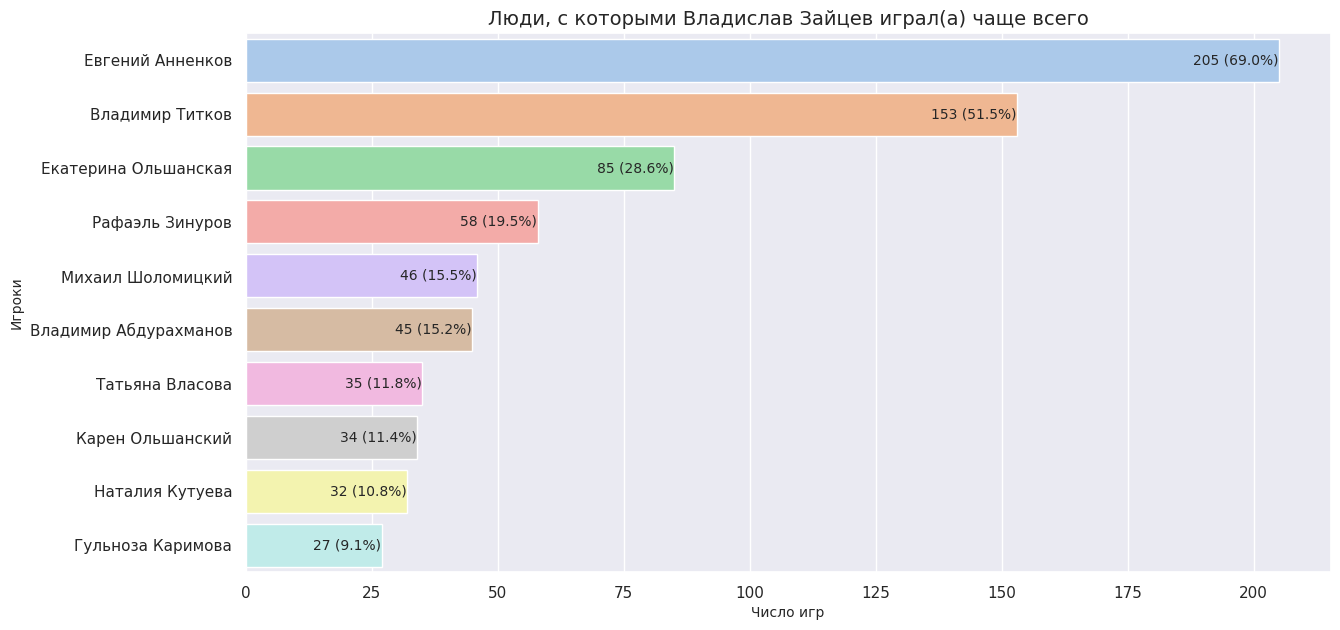

In [7]:
# For a single player:

df_all_players, player_name, last_row_index = chgk_player(84800) # PASTE THE PLAYER ID HERE
chgk_diagram(df_all_players, player_name, last_row_index)

The performance may be improved in the future.